<a href="https://colab.research.google.com/github/kimjeongsoo20190147/bigdata_bitcoin_predict/blob/main/bitcoin_per_hour_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
###############################################
# 1) CSV 데이터 불러오기 & DateTime 인덱스 설정
###############################################

# pd.read_csv()에 parse_dates 옵션으로 datetime 파싱
data = pd.read_csv('btc_1h_data.csv', parse_dates=['Open time'])

# 데이터 열 확인
print("===== CSV Columns =====")
print(data.columns)

# 1-1) 중복 인덱스 제거 (Open time 중복 방지)
# CSV에 동일 'Open time'이 여러 번 있을 경우를 대비
data.drop_duplicates(subset=['Open time'], inplace=True)

# 1-2) 'Open time' 컬럼을 인덱스로 설정 & 정렬
data.set_index('Open time', inplace=True)
data.sort_index(inplace=True)

# 1-3) 숫자형 변환 확인 (Close 컬럼 등)
# 혹시 문자열로 인식되었다면 to_numeric으로 변환 시도
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # 숫자로 변환 불가 시 NaN

# 1-4) 결측치(NaN) 처리
data.dropna(subset=['Close'], inplace=True)

# 최종 확인
print("\n===== Head of the Data =====")
print(data.head())
print("\n===== Tail of the Data =====")
print(data.tail())
print("\nData shape:", data.shape)

===== CSV Columns =====
Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

===== Head of the Data =====
                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13529.01  443.356199   
2018-01-01 01:00:00  13528.99  13595.89  13155.38  13203.06  383.697006   
2018-01-01 02:00:00  13203.00  13418.43  13200.00  13330.18  429.064572   
2018-01-01 03:00:00  13330.26  13611.27  13290.00  13410.03  420.087030   
2018-01-01 04:00:00  13434.98  13623.29  13322.15  13601.01  340.807329   

                    Close time  Quote asset volume  Number of trades  \
Open time                                                              
2018-01-01 00:00:00    00:00.0         5993909.8

In [9]:
#############################################
# 2) 훈련 데이터 설정 (2020-01-01 ~ 2024-11-30)
#############################################
start_date = '2020-01-01'
end_date   = '2024-11-30'  # 훈련 데이터의 종료일을 2024년 11월 30일로 설정
train = data.loc[start_date:end_date]

# 훈련 데이터 종가 추출
train_close = train['Close'] if 'Close' in train.columns else pd.Series(dtype=float)

print("\n===== Train Close Tail =====")
print(train_close.tail())


===== Train Close Tail =====
Open time
2024-11-30 19:00:00    97019.68
2024-11-30 20:00:00    96967.99
2024-11-30 21:00:00    96792.02
2024-11-30 22:00:00    96466.11
2024-11-30 23:00:00    96407.99
Name: Close, dtype: float64


In [10]:
##################################################
# 3) 기준 구간(base) 설정 & 윈도우 + next_date 설정
##################################################
# 기준 구간: 2024-12-01 00:00:00 ~ 2024-12-02 00:00:00
base_start_date = pd.to_datetime("2024-12-01 00:00:00")
base_end_date   = pd.to_datetime("2024-12-02 00:00:00")

# 기준 구간 추출
base = data.loc[base_start_date:base_end_date]['Close'] if not data.loc[base_start_date:base_end_date].empty else pd.Series(dtype=float)

window_size = len(base)
next_date = 30          # 예측할 미래 시간 수 (30시간)

print("\n===== Base Period =====")
print(base)


===== Base Period =====
Open time
2024-12-01 00:00:00    96340.60
2024-12-01 01:00:00    96106.62
2024-12-01 02:00:00    95776.22
2024-12-01 03:00:00    96336.75
2024-12-01 04:00:00    96515.52
2024-12-01 05:00:00    96308.83
2024-12-01 06:00:00    96327.66
2024-12-01 07:00:00    96472.97
2024-12-01 08:00:00    97048.01
2024-12-01 09:00:00    97030.15
2024-12-01 10:00:00    96811.99
2024-12-01 11:00:00    97108.89
2024-12-01 12:00:00    96774.49
2024-12-01 13:00:00    97071.93
2024-12-01 14:00:00    97289.78
2024-12-01 15:00:00    97028.02
2024-12-01 16:00:00    97187.98
2024-12-01 17:00:00    97299.97
2024-12-01 18:00:00    97118.69
2024-12-01 19:00:00    97178.73
2024-12-01 20:00:00    97099.99
2024-12-01 21:00:00    97767.62
2024-12-01 22:00:00    97562.56
2024-12-01 23:00:00    97185.18
2024-12-02 00:00:00    97436.75
Name: Close, dtype: float64


In [11]:
####################################
# 4) 과거(Train) 데이터 패턴 탐색
####################################
def cosine_similarity(x, y):
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
        return 0.0
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# 패턴 매칭을 위한 train_close 내에서 window_size 만큼 순회
moving_cnt = len(train_close) - window_size

if window_size == 0:
    print("\n[주의] 기준 구간(base)에 데이터가 없습니다. (window_size=0)")
    sim_list = []
else:
    sim_list = []
    # base 구간 정규화
    if base.size > 0 and (base.max() != base.min()):
        base_norm = (base - base.min()) / (base.max() - base.min())
    else:
        # 모든 값이 동일하거나 base가 비었을 때
        base_norm = np.zeros(len(base))

    for i in range(moving_cnt):
        target = train_close.iloc[i : i + window_size]
        # target이 정확히 window_size 크기이고, 값이 동일하지 않을 경우 정규화
        if target.size == window_size and (target.max() != target.min()):
            target_norm = (target - target.min()) / (target.max() - target.min())
            sim = cosine_similarity(base_norm, target_norm)
            sim_list.append(sim)
        else:
            sim_list.append(0.0)  # 유사도 0으로 설정

    sim_series = pd.Series(sim_list)
    print("\n===== 유사도 상위 10개 인덱스 =====")
    top10 = sim_series.sort_values(ascending=False).head(10)
    print(top10)

    # 가장 높은 유사도 구간 인덱스
    if len(top10) > 0:
        best_idx = top10.index[0]
        best_sim = top10.iloc[0]
        print(f"\n가장 비슷한 패턴 인덱스: {best_idx}, 유사도: {best_sim:.4f}")

        # 실제 train_close 인덱스 (시계열)
        pattern_start_date = train_close.index[best_idx]
        pattern_end_date   = train_close.index[best_idx + window_size - 1]
        print(f"해당 패턴 구간: {pattern_start_date} ~ {pattern_end_date}")



===== 유사도 상위 10개 인덱스 =====
16486    0.987595
37189    0.985444
13584    0.984708
11341    0.984164
36388    0.984070
24718    0.983968
12194    0.983912
39992    0.983816
7979     0.983421
39993    0.983412
dtype: float64

가장 비슷한 패턴 인덱스: 16486, 유사도: 0.9876
해당 패턴 구간: 2021-11-19 05:00:00 ~ 2021-11-20 05:00:00


In [12]:
#############################################
# 5) 유사도 0.98 이상인 구간들의 이후 30시간 패턴 평균 계산
#############################################
threshold = 0.98
if window_size > 0 and not sim_series.empty:
    high_sim_indices = sim_series[sim_series >= threshold].index
    patterns_ext = []

    for idx in high_sim_indices:
        prediction = train_close.iloc[idx + window_size : idx + window_size + next_date]
        if len(prediction) == next_date and prediction.max() != prediction.min():
            prediction_norm = (prediction - prediction.min()) / (prediction.max() - prediction.min())
            patterns_ext.append(prediction_norm.values)

    if len(patterns_ext) > 0:
        mean_pattern_extended = np.mean(patterns_ext, axis=0)
        print(f"\n유사도 0.98 이상인 패턴 수: {len(patterns_ext)}")
    else:
        mean_pattern_extended = None
        print("\n유사도 0.98 이상인 패턴이 없습니다.")
else:
    mean_pattern_extended = None
    print("\n유사도 0.98 이상인 패턴이 없습니다.")


유사도 0.98 이상인 패턴 수: 52


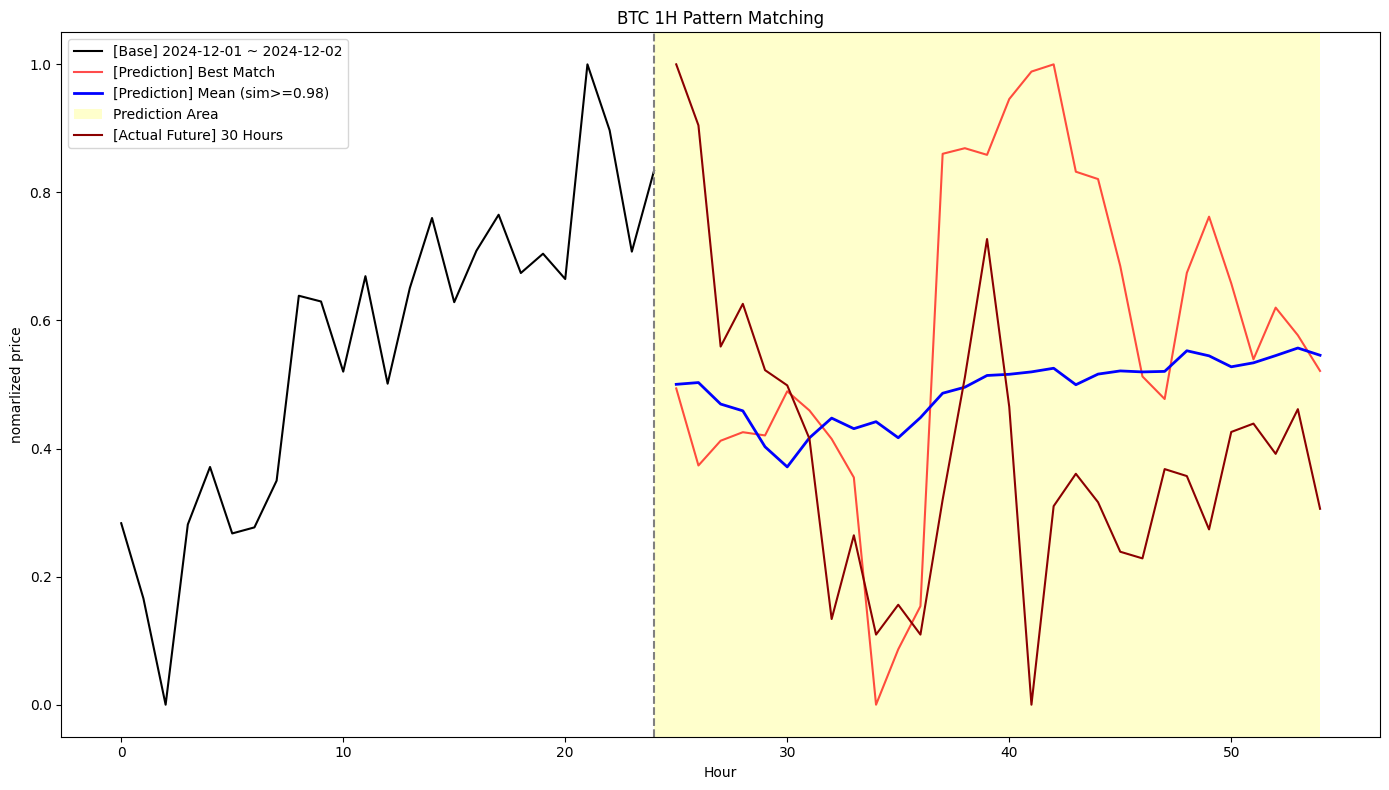

In [15]:
################################################
# 6) 시각화 예시 (기준 구간 vs 최적 패턴 vs 평균 패턴 vs 실제 미래)
################################################
plt.figure(figsize=(14, 8))  # 그래프 크기 약간 확대

# 기준 구간(normalized)
if len(base) > 0 and (base.max() != base.min()):
    base_norm = (base - base.min()) / (base.max() - base.min())
else:
    base_norm = np.zeros(len(base))

plt.plot(range(0, len(base_norm)), base_norm.values, label='[Base] 2024-12-01 ~ 2024-12-02', color='black')

# 가장 유사한 구간 패턴 시각화(normalized)
if 'best_idx' in locals() and window_size > 0:
    # 유사한 패턴의 이후 30시간 추출
    prediction_start_idx = best_idx + window_size
    prediction_end_idx = prediction_start_idx + next_date
    best_prediction = train_close.iloc[prediction_start_idx : prediction_end_idx]

    if len(best_prediction) == next_date and best_prediction.max() != best_prediction.min():
        best_prediction_norm = (best_prediction - best_prediction.min()) / (best_prediction.max() - best_prediction.min())
    else:
        best_prediction_norm = np.zeros(len(best_prediction))

    plt.plot(range(len(base_norm), len(base_norm) + len(best_prediction_norm)),
             best_prediction_norm.values, label='[Prediction] Best Match', color='red', alpha=0.7)

# 유사도 0.97 이상인 구간들의 평균 패턴 시각화(normalized)
if mean_pattern_extended is not None:
    plt.plot(range(len(base_norm), len(base_norm) + len(mean_pattern_extended)),
             mean_pattern_extended, label='[Prediction] Mean (sim>=0.98)', color='blue', linewidth=2)

# 기준 구간과 예측 영역 경계선
plt.axvline(x=len(base_norm)-1, color='gray', linestyle='--')
plt.axvspan(len(base_norm)-1,
            len(base_norm) + len(best_prediction_norm)-1,
            facecolor='yellow', alpha=0.2, label='Prediction Area')

# 실제 이후 30시간의 실제 가격 데이터 가져오기
future_start_date = base_end_date  # 2024-12-02 00:00:00

actual_future = data.loc[future_start_date:].iloc[1 : 1 + next_date]['Close'] if not data.loc[future_start_date:].empty else pd.Series(dtype=float)

# 실제 미래 데이터가 충분한지 확인
if len(actual_future) == next_date:
    # 정규화
    if actual_future.max() != actual_future.min():
        actual_future_norm = (actual_future - actual_future.min()) / (actual_future.max() - actual_future.min())
    else:
        actual_future_norm = np.zeros(len(actual_future))

    # x축에서의 시작 위치 설정 (기준 구간의 끝)
    start_x = len(base_norm)  # 24

    # 실제 미래 데이터를 진한 빨간색 선으로 플롯 (24~54)
    plt.plot(range(start_x, start_x + len(actual_future_norm)),
             actual_future_norm.values, label='[Actual Future] 30 Hours', color='darkred')
else:
    print("\n[주의] 테스트 데이터가 30시간 분량 충분치 않아 실제 미래 데이터를 시각화하지 못했습니다.")

plt.title("BTC 1H Pattern Matching")
plt.xlabel("Hour")
plt.ylabel("nomarlized price")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
##################################################
# 7) 실제 미래와 비교하여 MSE 계산
##################################################
if 'best_prediction_norm' in locals() and len(best_prediction_norm) == next_date and len(actual_future) == next_date:
    # 실제 30시간 후 가격 정규화
    if actual_future.max() != actual_future.min():
        actual_future_norm = (actual_future - actual_future.min()) / (actual_future.max() - actual_future.min())
    else:
        actual_future_norm = np.zeros(len(actual_future))

    # MSE 계산
    mse = np.mean((best_prediction_norm - actual_future_norm.values)**2)
    print(f"\n예측 vs 실제(30시간) MSE: {mse:.6f}")


예측 vs 실제(30시간) MSE: 0.137482
